In [49]:
#imports for building model
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
import re
from nltk.stem.porter import PorterStemmer
import nltk
from nltk.corpus import stopwords
#imports for training the model
from sklearn.model_selection import train_test_split
import pickle
from sklearn.linear_model import LogisticRegressionCV
#model evaluation
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools

# Loading and Buliding Model

In [2]:
#upload the dataset
from google.colab import files
upload = files.upload()

Saving movie_data.csv to movie_data.csv


In [4]:
data = pd.read_csv('movie_data.csv')

data.head(10)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
5,Leave it to Braik to put on a good show. Final...,1
6,Nathan Detroit (Frank Sinatra) is the manager ...,1
7,"To understand ""Crash Course"" in the right cont...",1
8,I've been impressed with Chavez's stance again...,1
9,This movie is directed by Renny Harlin the fin...,1


In [12]:
count =CountVectorizer()

docs = (['The sun is shining',
         'The weather is good',
         'The sun is shining, the weather is good, and one and one is two'])
bagdata = count.fit_transform(docs)

print(count.vocabulary_)
print(bagdata.toarray())

{'the': 6, 'sun': 5, 'is': 2, 'shining': 4, 'weather': 8, 'good': 1, 'and': 0, 'one': 3, 'two': 7}
[[0 0 1 0 1 1 1 0 0]
 [0 1 1 0 0 0 1 0 1]
 [2 1 3 2 1 1 2 1 1]]


In [20]:
np.set_printoptions(precision=2)

tfidf = TfidfTransformer(use_idf=True, norm ='l2', smooth_idf = True)

print(tfidf.fit_transform(bagdata).toarray())

[[0.   0.   0.43 0.   0.56 0.56 0.43 0.   0.  ]
 [0.   0.56 0.43 0.   0.   0.   0.43 0.   0.56]
 [0.5  0.19 0.45 0.5  0.19 0.19 0.3  0.25 0.19]]


In [22]:
def preprocessor(text):
  text =re.sub('<[^>]*>', '', text)
  emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
  text = re.sub('[\W]+', ' ', text.lower()) + ' '.join(emoticons).replace('-', '')
  
  return text

preprocessor("This is a :) regex test :-( !")

'this is a regex test :) :('

In [25]:
data['review'] = data['review'].apply(preprocessor)

In [31]:
#Tokenization

porter = PorterStemmer()

def tokenizer(text):
  return text.split()

def tokenizer_stemmer(text):
  return[porter.stem(word) for word in text.split()]

tokenizer('walkers like walking thus they walk')

['walkers', 'like', 'walking', 'thus', 'they', 'walk']

In [32]:
tokenizer_stremmer('walkers like walking thus they walk')

['walker', 'like', 'walk', 'thu', 'they', 'walk']

In [35]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [38]:
stop = stopwords.words('english')
[w for w in tokenizer_stemmer('walkers like walking thus they walk') if w not in stop]

['walker', 'like', 'walk', 'thu', 'walk']

In [41]:
#Transform text Data into vectors
tfidf = TfidfVectorizer(strip_accents=None,
                         lowercase=True,
                         preprocessor=None,  # applied preprocessor using the re import
                         tokenizer=tokenizer_stemmer,
                         use_idf=True,
                         norm='l2',
                         smooth_idf=True)

y = data.sentiment.values
X = tfidf.fit_transform(data.review)


# Model Training

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.5, shuffle=False)

clf = LogisticRegressionCV(cv=5,
                           scoring='accuracy',
                           random_state=0,
                           n_jobs=-1,
                           verbose=3,
                           max_iter=300).fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.2min finished


In [45]:
saved_model = open('saved_model.sav', 'wb')
pickle.dump(clf, saved_model)
saved_model.close()

# Model Evaluation

In [46]:
filename = 'saved_model.sav'
saved_clf = pickle.load(open(filename, 'rb'))

In [47]:
clf.score(X_test, y_test)

0.89608

In [48]:
yhat = clf.predict(X_test)
yhat

array([0, 1, 1, ..., 0, 1, 1])

In [50]:
#creating a confusion matrix using matplotlib
#show an array of the confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
print(confusion_matrix(y_test, yhat, labels=[1,0]))

[[11206  1267]
 [ 1331 11196]]


Confusion matrix, without normalization
[[11206  1267]
 [ 1331 11196]]


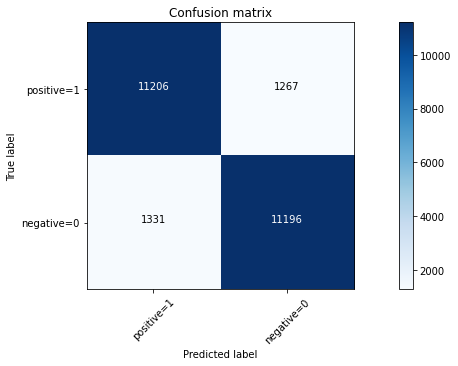

In [51]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,0])
np.set_printoptions(precision=2)
#represent confusion matrix in a diagram
plt.figure(figsize=(13,5))
plot_confusion_matrix(cnf_matrix, classes=['positive=1','negative=0'],normalize= False,  title='Confusion matrix')